<font size=5> Bayesian Logistic Regression <font> 


Use your logistic regression data to fit a standard logistic regression model and a Bayesian logistic regression model. Use the same predictor variables. Compare the performance of the model.

In [9]:
#Load requiered libraries
library(dplyr)
library(pROC)

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var




In [2]:
#load data
df <- read.csv("loan_dataset.csv", stringsAsFactors = TRUE)

#convert target value to factor
df <- df %>% mutate(Loan_Status = as.factor(Loan_Status))

**Split data to train and test sets:**

In [3]:
idx <- caret::createDataPartition(df$Loan_Status, p = 0.7, list = FALSE)
train_set <- df[idx, ]
test_set <- df[-idx,]

**Fit regular logistic regression model**

In [4]:
glm_standard  <- glm(Loan_Status ~ Gender + Married + Credit_History + Property_Area + Dependents,
                    data = train_set,
                    family = binomial()
                    )
summary(glm_standard)


Call:
glm(formula = Loan_Status ~ Gender + Married + Credit_History + 
    Property_Area + Dependents, family = binomial(), data = train_set)

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -3.19808    0.65043  -4.917 8.80e-07 ***
GenderMale              0.35622    0.38021   0.937   0.3488    
MarriedYes              0.48029    0.35131   1.367   0.1716    
Credit_History          3.85954    0.54876   7.033 2.02e-12 ***
Property_AreaSemiurban  0.78855    0.36319   2.171   0.0299 *  
Property_AreaUrban     -0.03804    0.35844  -0.106   0.9155    
Dependents1            -0.50150    0.41573  -1.206   0.2277    
Dependents2            -0.04590    0.45085  -0.102   0.9189    
Dependents3+           -0.40091    0.53228  -0.753   0.4513    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 416.52  on 336  degrees of freedom
Residual deviance: 304

**Fit a Baysian logistic regression model with prior normal distribution**

In [5]:
stan_glm_product_normal <- rstanarm::stan_glm(Loan_Status ~ Gender + Married + Credit_History + Property_Area + Dependents,
                                            data = train_set,
                                            family = binomial(), 
                                            prior = rstanarm::product_normal()
                                            )



SAMPLING FOR MODEL 'bernoulli' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000146 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.46 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.417 seconds (Warm-up)
Chain 1:                2.96 seconds (Sampling)
Chain 1:                6.377

In [6]:
#Standard Logistic Regression Coefficients
coef_standard <- coef(glm_standard) %>%
                                        round(2)

#Baysian Logistic regression with Normal Prior Distribution
coef_baysian <- coef(stan_glm_product_normal) %>% 
                                                  round(2)

rbind(coef_standard, coef_baysian)

,(Intercept),GenderMale,MarriedYes,Credit_History,Property_AreaSemiurban,Property_AreaUrban,Dependents1,Dependents2,Dependents3+
coef_standard,-3.20,0.36,0.48,3.86,0.79,-0.04,-0.50,-0.05,-0.40
coef_baysian,-2.83,0.19,0.27,3.66,0.60,-0.04,-0.18,0.02,-0.06


Interestingly the scale of the standard glm coefficients are larger, but they are close to their corresponding ones in Baysian model.

In [7]:
#Standard Logistic Regression prediction
glm_standard_prob <-    predict(glm_standard, 
                             newdata = test_set[,-11],
                             type = "response"
                                )


#Baysian Logistic regression with Normal Prior Distribution prediction
glm_product_normal_prob <-    predict(stan_glm_product_normal, 
                                newdata = test_set[,-11],
                                type = "response"
                                )

**Predictions and Performance:**

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



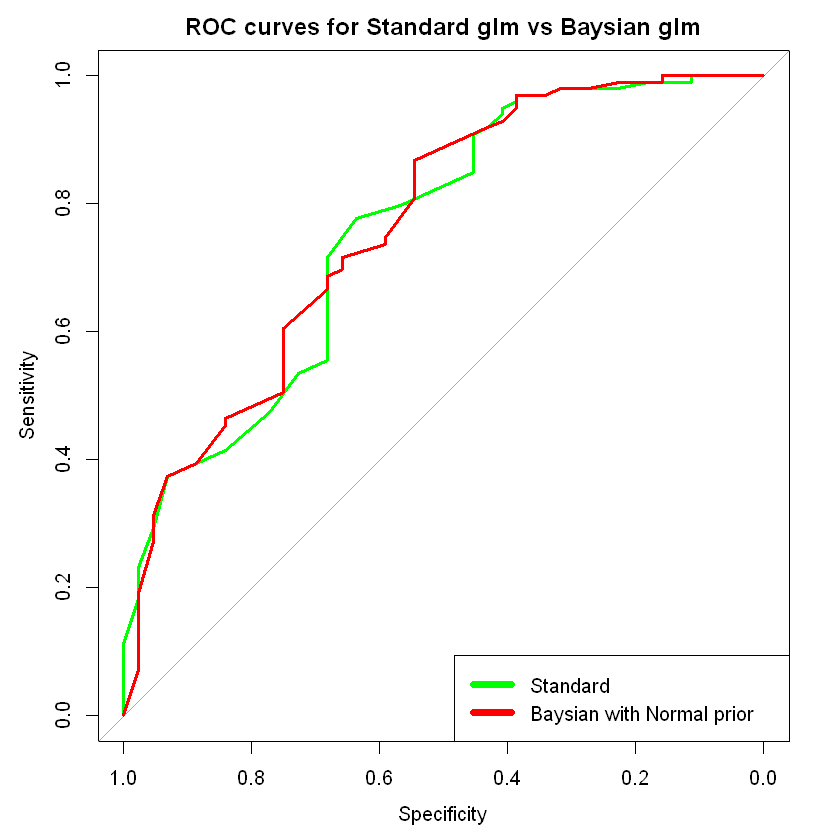

In [10]:
plot(roc(test_set$Loan_Status, glm_standard_prob), lwd = 3, col = "green", main = "ROC curves for Standard glm vs Baysian glm")
plot(roc(test_set$Loan_Status, glm_product_normal_prob), lwd = 3, add =TRUE, col = "red")
legend("bottomright", 
       legend = c("Standard", "Baysian with Normal prior"), 
       col = c("green", "red"), 
       lty = 1, 
       cex = 1,
      lwd = 6)

In [11]:
auc(roc(test_set$Loan_Status, glm_standard_prob)) %>% round(3)
auc(roc(test_set$Loan_Status, glm_product_normal_prob)) %>% round(3)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 0.757

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 0.765

Performance of the models are pretty close, the auc of both are 0.76, however the Baysian glm with normal distribution prior is slightly better.